<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Time_Series/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import yfinance as yf
import pandas as pd
import numpy as np
from numpy.fft import fftfreq

In [115]:
from google.colab import drive

# Mount your Google Drive to the local /content/drive directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
from os import mkdir
try:
  # Creating a folder to clone repo
  local_folder = "/content/drive/My Drive/"
  name_folder = "repo"
  repo_folder = f"{local_folder}/{name_folder}"

  mkdir(repo_folder)
except:
  pass

In [117]:
# UNCOMMENT TIS CODE TO CLONE THE REPO IN GOOGLE DRIVE. THE REPO NEEDS TO E PUBLIC

#%cd /content/drive/My Drive/repo

#! git clone https://github.com/Aerospace87/ML-projects

In [118]:
# Running lirary notebook wit useful time series function

%run "/content/drive/My Drive/repo/ML-projects/tensorflow/Time_Series/Time_series_libraries.ipynb"

In [119]:
code_dict = {
    "Caterpillar Inc.": "CAT",
    "CNH Industrial N.V.": "CNH",
    "GE Aerospace" :"GE"
}

cat = yf.Ticker(code_dict["GE Aerospace"])

In [120]:
# get historical market data
hist = cat.history(period="max")

In [121]:
hist = hist["Open"].to_frame()

In [122]:
# Convert the index from timestamp to date
hist = hist.reset_index()
hist["Date"] = hist["Date"].dt.date
hist = hist.set_index("Date")

<Axes: xlabel='Date'>

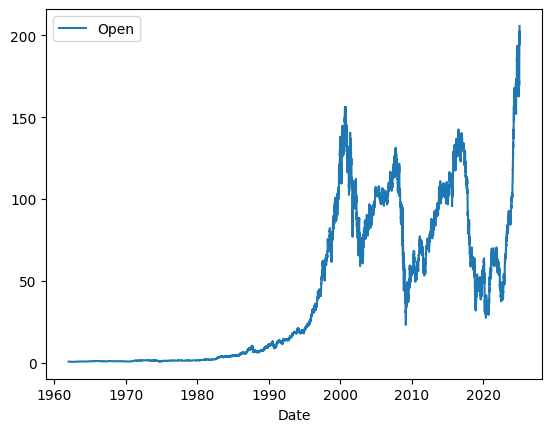

In [123]:
hist.reset_index().plot(x="Date",y="Open")

## Imputing Missing Values
For some timesteps some values may be missing therefore we impute cnsidering the last not-null value

In [124]:
# Check if all the data points are equally spaced

beginning_timestamp = hist.index.min()
last_timestamp = hist.index.max()
delta_t = hist.index[1] - beginning_timestamp


equispaced_index = pd.date_range(start = beginning_timestamp,
              end = last_timestamp,
              freq = delta_t
)

equispaced_df = pd.DataFrame(index = equispaced_index,
             data = {"test_col" : np.zeros(equispaced_index.size)}
).reset_index()


equispaced_df["index"] = equispaced_df["index"].dt.date

hist = equispaced_df.merge(hist.reset_index(),
                    how='left',
                    left_on = 'index',
                    right_on='Date'
)

cols = ["index", "Open"]

hist = hist[cols]

In [125]:
# Imputing the nulls with the last non null value

nulls_indices = hist[hist["Open"].isna()].index.copy()

for idx in nulls_indices:

  if idx == 0:
    hist.iloc[(idx, 1)] = 0.0
  elif idx >= 1:
    hist.iloc[(idx, 1)] = hist.iloc[(idx - 1, 1)]

hist.rename(columns={"index": "Date"}, inplace=True)

hist = hist.set_index("Date")

In [126]:
hist.describe()

,Open
count,23041.000000
mean,42.186015
std,46.234648
min,0.468143
25%,1.397031
50%,18.072274
75%,80.050085
max,205.839996


### Moving Average

In [127]:
window_size = 1

mov_average_col = "Open_mov_avg"
hist[mov_average_col] = moving_average_forecast(hist["Open"], window_size)

<Axes: xlabel='Date'>

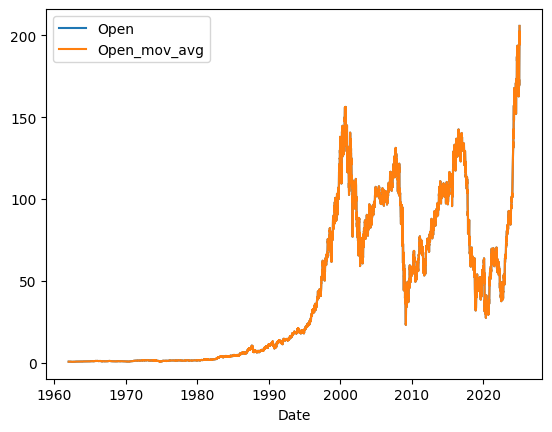

In [128]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_mov_avg"])

### First Difference

In [129]:
hist["Open_diff"], first_q_values, original_index =  diff_series(hist["Open"], 3)

<Axes: xlabel='Date'>

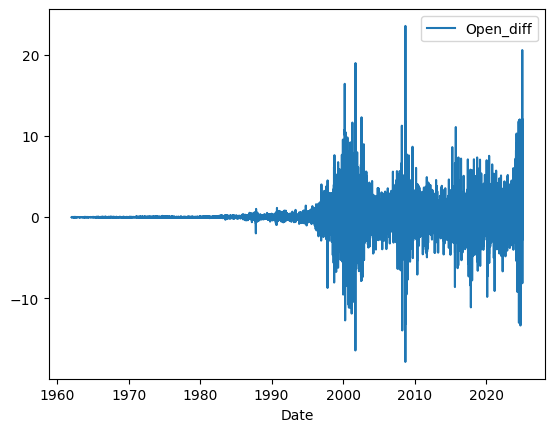

In [130]:
hist.reset_index().plot(x="Date", y="Open_diff")

### Series Integration

In [131]:
hist["Open_diff_integrated"] = integrate_series(first_q_values, hist["Open_diff"])

<Axes: xlabel='Date'>

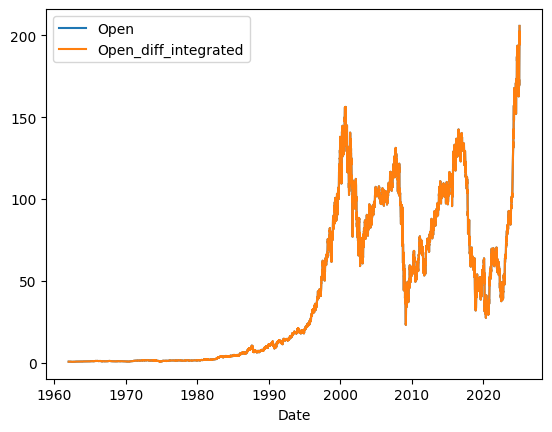

In [132]:
hist.reset_index().plot(x="Date", y= ["Open", "Open_diff_integrated"])

## Training and Validation Test Split

In [133]:
number_time_steps = hist.shape[0]
train_perc = 80.0
train_index = int(np.floor(number_time_steps * train_perc/100.0))

train_set = hist.iloc[:train_index]
val_set = hist.iloc[train_index:]

## Naive Forecast

Naive forecast predicts value at time $t+1$ as equal to the value of the series at time $t$. This will be our baseline model to evaluate all the models against it. Note that naive forecast $\hat{x}_{t+1}$ is equivalent to moving average $\overline{x}_t$ at time $t$ with $w=1$ in fact:

\begin{align}
\hat{x}_{t+1} \approx \overline{x}_t = \frac{1}{1} \sum_{i = t-1+1}^t x_i = \sum_{i = t}^t x_i = x_{t}
\end{align}


In [134]:
data_one_time_tep_before = hist["Open"][train_index - 1:-1].values

val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )

<ipython-input-134-c56b9a4f2e39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_set["naive_forecast"] = pd.Series(data = data_one_time_tep_before, index =val_set.index )


<Axes: xlabel='Date'>

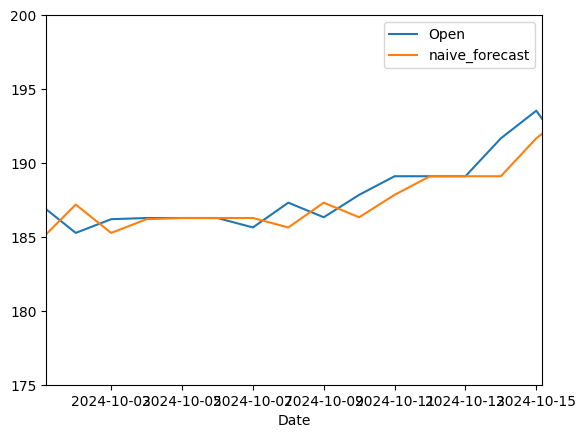

In [135]:
val_set.reset_index().plot(x="Date",
                           y=["Open", "naive_forecast"],
                           xlim = ('2024-10-01 00:00:00-04:00', '2024-10-15 00:00:00-04:00'),
                           ylim = (175, 200))

In [136]:
errors = val_set["Open"] - val_set["naive_forecast"]
abs_errors = np.abs(errors)
MAE = abs_errors.mean()
print(f"The Mean Absolute Error (MAE) for the naive forecast is {MAE}")

The Mean Absolute Error (MAE) for the naive forecast is 0.719924296755603


## Moving Average Forecast

 Let's consider the moving average in the validation set with varying window size:

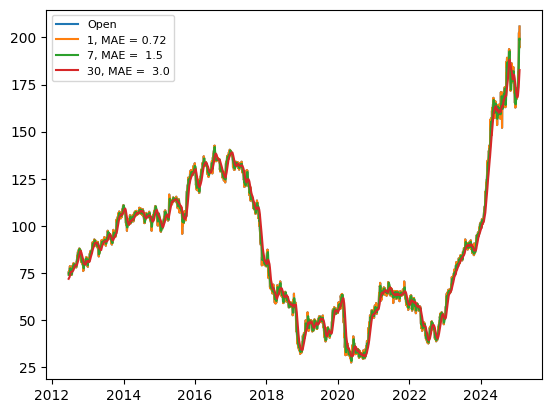

In [137]:
import matplotlib.pyplot as plt


windows = [1, 7, 30]

true_val = val_set["Open"]


plt.plot(val_set.index, true_val, label = "Open")

for w in windows:

  mov_val = moving_average_forecast(hist["Open"][train_index - w:], w)
  pred_val_index = mov_val.index + delta_t
  pred_val = pd.Series(mov_val.values, index = pred_val_index)[:-1]

  errors = true_val - pred_val
  abs_errors = np.abs(errors)
  MAE = abs_errors.mean()

  label = f"{str(w)}, MAE = {MAE:{4}.{2}}"

  plt.plot(mov_val.index, mov_val, label = label)

plt.legend(loc="upper left")
plt.legend(fontsize = 8.0)
plt.show()

### Fourier Transform
Fourier transform and Power Spectral Density (PSD) are used to find seasonality in the timeseries. The frequencies of seasonality may be identifying by peaks in the PSD.

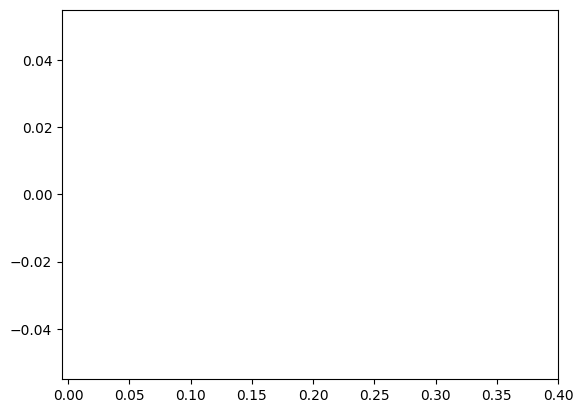

In [138]:
plot_psd(hist["Open_diff"].values, 10)

Therefore there is no seasonality in the time series.

## Machine Learning

## Stationarity Check

In [139]:
diff = hist["Open_diff"][~hist["Open_diff"].isna()].values

In [140]:
check_stationary(diff)

The series is stationary because there is not unit root in the series 
based on a significance of 5.0% (Alternate Hypothesis).


### Partial Auto Correlation Function (PACF)

<Figure size 1200x600 with 0 Axes>

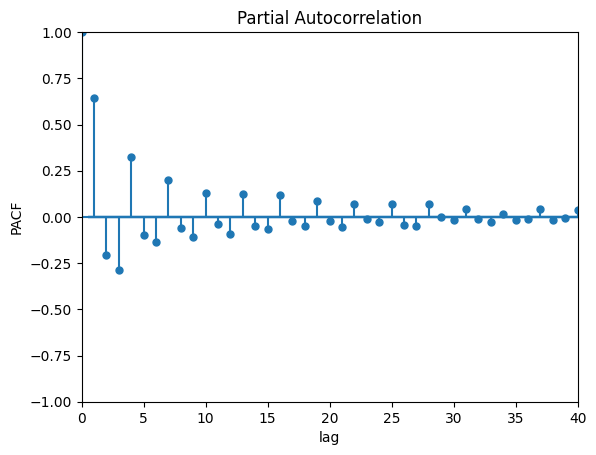

In [141]:
plot_PACF(diff)

<Figure size 1200x600 with 0 Axes>

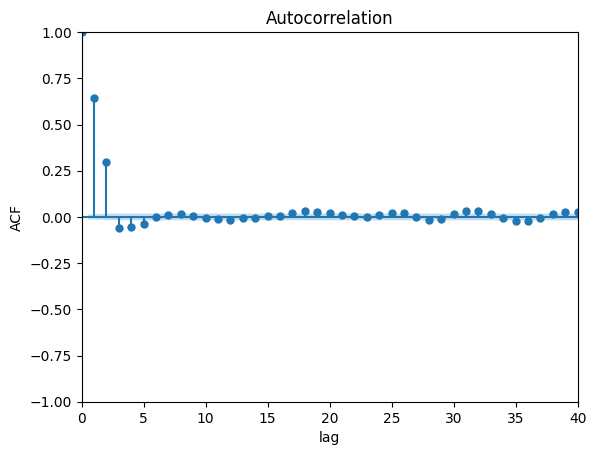

In [142]:
plot_ACF(diff)

### Time Window

We want to forecast the next value of a time series using a time window made of the previous $n_w$ time steps. Each time window will have an initial time represented by the second time instant of the preceding window. For example for window $j$ and $j+1$ we will have:

\begin{aligned}
window_j: \hspace{2cm} t_j, t_{j+1}, ... , t_{j+n_w-1}, \\
window_{j+1}: \hspace{2cm} {t_{j+1}}, t_{j+2}, ... , t_{j+n_w}
\end{aligned}

In order to train a supervised machine learning model we need a label for each training sample. In this case, we will have that for each window the first $n_{w-1}$ time steps represents the training sample while the last time step $t_{n_w}$ represents the target to predict.


In [143]:
import tensorflow as tf

In [144]:
diff_training_values = diff[:train_index]
diff_validation_values = diff[train_index:]

In [145]:
# Creation of a tensorflow dataset from list
diff_train_set = tf.data.Dataset.from_tensor_slices(diff_training_values)
diff_val_set = tf.data.Dataset.from_tensor_slices(diff_validation_values)

In [146]:
samples_per_window = 10
# Shift used to make a window starting with the second time step of the previous
# window
# Drop Remainder is used to obtain all windows with an equal number of samples_per_window
# Beacuse ML models expect same number of training examples in each window
diff_train_set = diff_train_set.window(size=samples_per_window, shift=1, drop_remainder=True)
diff_val_set = diff_val_set.window(size=samples_per_window, shift=1, drop_remainder=True)

# Storing te numer of windows into a variable used later to shaffle
# the dataset
number_of_windows_train = tf.data.experimental.cardinality(diff_train_set).numpy()
number_of_windows_val = tf.data.experimental.cardinality(diff_train_set).numpy()

In [147]:
# Printing the structure of the windows for the first
# five windows to check data
for idx, window in enumerate(diff_train_set.take(5)):
  string = f"WINDOW {idx}: "
  for elem in window:
    string += f"{str(elem.numpy())[:8]} "

  print(string)

WINDOW 0: -0.01559 -0.01039 -0.00727 -0.01559 -0.01663 -0.01351 0.005198 0.007276 0.004157 0.001039 
WINDOW 1: -0.01039 -0.00727 -0.01559 -0.01663 -0.01351 0.005198 0.007276 0.004157 0.001039 -0.00727 
WINDOW 2: -0.00727 -0.01559 -0.01663 -0.01351 0.005198 0.007276 0.004157 0.001039 -0.00727 -0.00207 
WINDOW 3: -0.01559 -0.01663 -0.01351 0.005198 0.007276 0.004157 0.001039 -0.00727 -0.00207 0.002080 
WINDOW 4: -0.01663 -0.01351 0.005198 0.007276 0.004157 0.001039 -0.00727 -0.00207 0.002080 -0.00311 


In [148]:
# Conversion of each window into a tensor.
# The batch method takes a number of samples_per_window and create a tensor
# The falt_map method run a function on a each dataset part of a nested
# dataset

diff_train_set = diff_train_set.flat_map(lambda window: window.batch(samples_per_window))
diff_val_set = diff_val_set.flat_map(lambda window: window.batch(samples_per_window))

In [149]:
# Printing the tensors that constitute the dataset
for idx, window in enumerate(diff_train_set.take(5)):
  print(f"TENSOR {idx}: {window.numpy()}")

TENSOR 0: [-0.01559327 -0.01039551 -0.00727715 -0.01559407 -0.01663331 -0.01351463
  0.00519825  0.00727665  0.00415798  0.00103917]
TENSOR 1: [-0.01039551 -0.00727715 -0.01559407 -0.01663331 -0.01351463  0.00519825
  0.00727665  0.00415798  0.00103917 -0.00727672]
TENSOR 2: [-0.00727715 -0.01559407 -0.01663331 -0.01351463  0.00519825  0.00727665
  0.00415798  0.00103917 -0.00727672 -0.00207866]
TENSOR 3: [-0.01559407 -0.01663331 -0.01351463  0.00519825  0.00727665  0.00415798
  0.00103917 -0.00727672 -0.00207866  0.00208025]
TENSOR 4: [-0.01663331 -0.01351463  0.00519825  0.00727665  0.00415798  0.00103917
 -0.00727672 -0.00207866  0.00208025 -0.00311856]


In [150]:
# We split each tensor into two tensors one representing the input features and
# the other the representing the target. The map method maps each tensor, part of
# the dataset into a couple of tensors. The first tensor has the first samples_per_window -1
# samples while the last has only the last sample

diff_train_set = diff_train_set.map(lambda window: (window[:-1], window[-1:]))
diff_val_set = diff_val_set.map(lambda window: (window[:-1], window[-1:]))

In [151]:
for input_sample, target_sample in diff_train_set.take(5):
  print(f"INPUT SAMPLE: {input_sample.numpy()} ", f"TARGET: {target_sample.numpy()}")

INPUT SAMPLE: [-0.01559327 -0.01039551 -0.00727715 -0.01559407 -0.01663331 -0.01351463
  0.00519825  0.00727665  0.00415798]  TARGET: [0.00103917]
INPUT SAMPLE: [-0.01039551 -0.00727715 -0.01559407 -0.01663331 -0.01351463  0.00519825
  0.00727665  0.00415798  0.00103917]  TARGET: [-0.00727672]
INPUT SAMPLE: [-0.00727715 -0.01559407 -0.01663331 -0.01351463  0.00519825  0.00727665
  0.00415798  0.00103917 -0.00727672]  TARGET: [-0.00207866]
INPUT SAMPLE: [-0.01559407 -0.01663331 -0.01351463  0.00519825  0.00727665  0.00415798
  0.00103917 -0.00727672 -0.00207866]  TARGET: [0.00208025]
INPUT SAMPLE: [-0.01663331 -0.01351463  0.00519825  0.00727665  0.00415798  0.00103917
 -0.00727672 -0.00207866  0.00208025]  TARGET: [-0.00311856]


In [152]:
# When a ML model is trained it is necessary that the samples are
# Independent and and Identically Distributed (IID)
# IID can be guaranteed by shuffllying the dataset
# therefore the order of the windows in the dataset changes but the structure
# of each window remains the same

diff_train_set = diff_train_set.shuffle(buffer_size = number_of_windows_train)
#diff_val_set = diff_train_set.shuffle(buffer_size = number_of_windows_val)

In [153]:
# Showing the shuffled dataset
for input_sample, target_sample in diff_train_set.take(5):
  print(f"INPUT SAMPLE: {input_sample.numpy()} ", f"TARGET: {target_sample.numpy()}")

INPUT SAMPLE: [ 0.00975204  0.00365731 -0.00731453 -0.00731453  0.01462785  0.02316149
  0.02316149  0.0012191   0.        ]  TARGET: [0.0048759]
INPUT SAMPLE: [ 8.65852772e-02 -1.08236251e-01  5.67539968e-06  1.08242965e-01
  1.29887617e-01 -2.16479473e-01 -4.76247940e-01 -3.68014318e-01
 -4.32930248e-02]  TARGET: [0.15153024]
INPUT SAMPLE: [-0.0392752   0.17672078  0.23563085  0.01963869 -0.07854003  0.15132596
  0.1908426   0.15132587 -0.03951746]  TARGET: [-0.05928059]
INPUT SAMPLE: [ 0.01379715  0.03587586  0.06899183  0.07175253  0.00827979 -0.0193162
 -0.0220769   0.00551998  0.        ]  TARGET: [0.00275923]
INPUT SAMPLE: [-1.37855660e-07 -2.54934171e-03  8.92366846e-03 -2.54950507e-03
 -8.92319036e-03 -8.92355276e-03 -1.27479715e-02  5.09883178e-03
  5.09927754e-03]  TARGET: [0.0089237]


In [154]:
windows_per_batch = 2

# Creating mini batches of windows_per_batch
diff_train_set = diff_train_set.batch(windows_per_batch).prefetch(1)
diff_val_set = diff_val_set.batch(windows_per_batch).prefetch(1)

In [155]:
for idx, (X_train, Y_train) in enumerate(diff_train_set.take(5)):
  print(f"BATCH {idx}:\nX_train={X_train.numpy()}, Y_train={Y_train.numpy()}")

BATCH 0:
X_train=[[ 2.07048136e-02  1.85259200e-02  6.53861910e-03 -9.74145690e-08
   3.26889904e-03 -6.53833499e-03 -1.08958345e-03 -4.35848260e-03
   5.44875143e-03]
 [ 3.54770257e-01  1.25220902e-01  1.87822991e-01  2.29558703e-01
   2.50421062e-01  2.71298131e-01  2.29562419e-01  8.34791576e-02
   1.46080942e-01]], Y_train=[[ 9.72979375e-08]
 [-4.41045636e-06]]
BATCH 1:
X_train=[[ 0.01121808 -0.01195334 -0.01526363 -0.0364117  -0.01324028 -0.00993
  -0.01986299 -0.02648286 -0.02979403]
 [ 0.0371852   0.13944094  0.11155183  0.11155512  0.00929938  0.00929971
  -0.08366853 -0.09296454 -0.11155628]], Y_train=[[-0.03310322]
 [-0.0836622 ]]
BATCH 2:
X_train=[[-1.22809858e-02 -3.68432645e-03 -1.09530459e-07 -2.45707507e-03
  -2.45707507e-03 -1.22805372e-03  4.91323014e-03  4.91323014e-03
   3.68431831e-03]
 [-2.27057196e-02  2.49727971e-01  4.31351346e-01  5.22165532e-01
   2.49731842e-01  6.81108712e-02  2.81841649e-06 -1.36214971e-01
  -1.58915941e-01]], Y_train=[[-0.00245584]
 [-0.15

In [156]:
for idx, (X_val, Y_val) in enumerate(diff_val_set.take(5)):
  print(f"BATCH {idx}:\nX_train={X_val.numpy()}, Y_train={Y_val.numpy()}")

BATCH 0:
X_train=[[-0.5713663  -1.17425379 -0.75760068 -0.53033034  0.87121022  1.66670163
   3.33342224  1.93188168  1.89399094]
 [-1.17425379 -0.75760068 -0.53033034  0.87121022  1.66670163  3.33342224
   1.93188168  1.89399094  1.21213712]], Y_train=[[ 1.21213712]
 [-0.15152458]]
BATCH 1:
X_train=[[-0.75760068 -0.53033034  0.87121022  1.66670163  3.33342224  1.93188168
   1.89399094  1.21213712 -0.15152458]
 [-0.53033034  0.87121022  1.66670163  3.33342224  1.93188168  1.89399094
   1.21213712 -0.15152458 -0.15152458]], Y_train=[[-0.15152458]
 [-1.51519076]]
BATCH 2:
X_train=[[ 0.87121022  1.66670163  3.33342224  1.93188168  1.89399094  1.21213712
  -0.15152458 -0.15152458 -1.51519076]
 [ 1.66670163  3.33342224  1.93188168  1.89399094  1.21213712 -0.15152458
  -0.15152458 -1.51519076 -0.83332109]], Y_train=[[-0.83332109]
 [-0.83332109]]
BATCH 3:
X_train=[[ 3.33342224  1.93188168  1.89399094  1.21213712 -0.15152458 -0.15152458
  -1.51519076 -0.83332109 -0.83332109]
 [ 1.93188168  1.8

## Linear Regression Model ( Classical AR Model)

In [157]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.losses import Huber

In [158]:
# We create a model with one Dense layer. By default the dense layer
# uses a linear activation function for all neurons. Therefore we will
# have a linear regression where the features are the previous n_w-1 time
# steps and the target is n_w-th time step

linear_model = Sequential([
  Dense(1, input_shape=[samples_per_window - 1])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [159]:
# Optimizer. Stochasting Gradient Descend with learning rate e-05
optimizer = SGD(learning_rate=1e-5, momentum=0.9)
linear_model.compile(loss=Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [160]:
linear_model.fit(diff_train_set, epochs=12, validation_data=diff_val_set)

Epoch 1/12
   9181/Unknown 15s 1ms/step - loss: 0.7598 - mae: 0.9668

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


9212/9212 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.7596 - mae: 0.9666 - val_loss: 1.5373 - val_mae: 1.9719
Epoch 2/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.4973 - mae: 0.6852 - val_loss: 1.0424 - val_mae: 1.4530
Epoch 3/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.3501 - mae: 0.5213 - val_loss: 0.8307 - val_mae: 1.2254
Epoch 4/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.2957 - mae: 0.4572 - val_loss: 0.7354 - val_mae: 1.1203
Epoch 5/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.2600 - mae: 0.4159 - val_loss: 0.6794 - val_mae: 1.0566
Epoch 6/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.2580 - mae: 0.4145 - val_loss: 0.6457 - val_mae: 1.0179
Epoch 7/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.2256 - mae: 0.3744 - val_loss: 0.6231 - val_mae: 0.9917
Epoch 8/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.2356 - mae: 0.3843 - val_loss: 0.6076 - val_mae: 0.9737
Epoch 9/12
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 1

In [161]:
def get_val_dataset(series, samples_per_window=2, windows_per_batch=2):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size=samples_per_window - 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(samples_per_window))
  dataset  = dataset.batch(windows_per_batch).prefetch(1)
  return dataset

In [162]:
test =  get_val_dataset(diff_training_values, samples_per_window= samples_per_window)

In [163]:
diff_pred = linear_model.predict(test)

9212/9212 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step


(-10.0, 10.0)

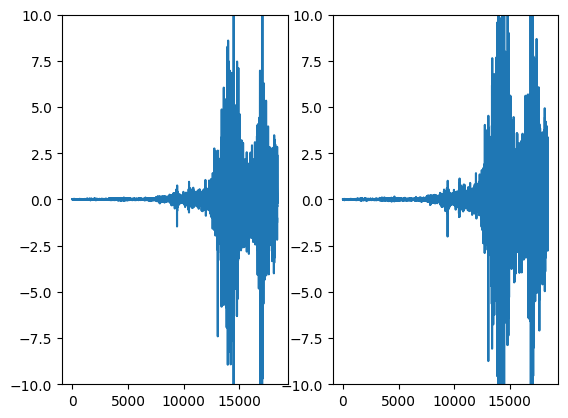

In [164]:
fig, axes = plt.subplots(1,2)
axes[0].plot(diff_pred, label='diff_pred')
axes[0].set_ylim(-10,10)
axes[1].plot(diff_training_values[samples_per_window - 2:], label='diff_validation')
axes[1].set_ylim(-10,10)